Testing TemSOMap using SpaTedSim simulated data

In [60]:
from temsomap import temso_utils
from temsomap import Mapper
import logging

In [61]:
import tangram as tg
import scanpy as sc
#import squidpy as sq
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
#import skimage
from Bio import Phylo
import seaborn as sns
from phylodm import PhyloDM
from scipy.spatial import distance
from biotite.sequence.phylo import neighbor_joining
import os

In [62]:
path = os.path.join('./data', 'spatial_map.csv')
ad_sp = pd.read_csv(path,sep = "\t")

In [63]:
ad_sp

,cellid,x,y,cell_type,clone
0,1,-0.394324,-0.000909,5,1
1,2,-0.632836,0.256601,5,1
2,3,-1.686518,-0.394255,5,1
3,4,-1.735865,-0.656128,5,1
4,5,-0.178073,0.468991,5,1
...,...,...,...,...,...
1019,1020,3.431115,-1.537616,5,4
1020,1021,3.208209,0.821632,6,4
1021,1022,2.114553,0.381347,6,4
1022,1023,2.472747,0.818110,5,4


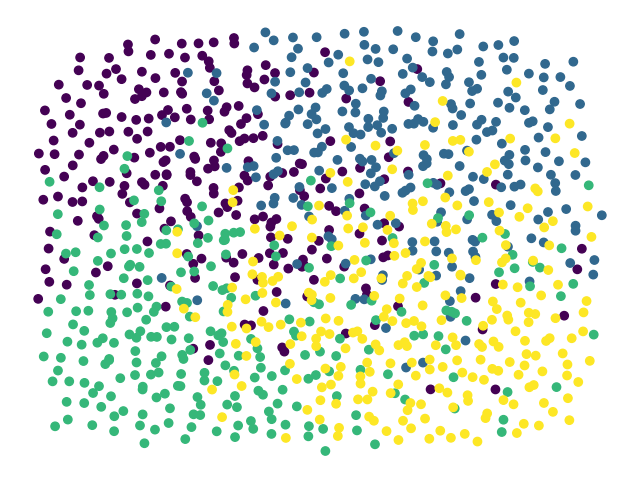

In [64]:
plt.figure(figsize=(8, 6))
xs = ad_sp.x.values
ys = ad_sp.y.values
plt.axis('off')
plt.scatter(xs, ys, c= ad_sp.clone.values);
plt.gca().invert_yaxis()

In [65]:
X = pd.read_csv('./data/counts.csv', sep=' ')
anndata_sc = AnnData(X)
X = X.to_numpy()
X.shape

(1024, 500)

In [66]:
cm = pd.read_csv('./data/character_matrix.txt', sep=' ')
#Z = Z.to_numpy()
cm

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32
cell_1,2,2,8,2,4,0,0,2,0,5,...,0,6,0,5,0,4,2,0,0,3
cell_2,2,2,8,2,0,0,0,2,0,5,...,5,6,0,5,0,4,2,0,0,3
cell_3,2,2,8,2,0,0,0,2,0,5,...,0,6,0,5,2,4,0,2,0,3
cell_4,2,2,8,2,0,12,0,2,0,5,...,0,6,0,5,2,4,0,0,0,3
cell_5,2,2,8,2,2,0,0,2,0,5,...,0,6,0,5,0,2,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_1020,6,0,0,9,0,0,0,0,3,2,...,0,0,2,3,0,13,0,0,2,0
cell_1021,2,13,0,9,0,0,11,5,2,2,...,0,2,2,3,0,13,2,0,2,2
cell_1022,2,13,0,9,0,0,12,5,0,2,...,9,2,2,3,0,13,2,0,2,0
cell_1023,0,13,0,9,0,0,0,0,0,2,...,0,2,2,3,0,13,2,0,2,0


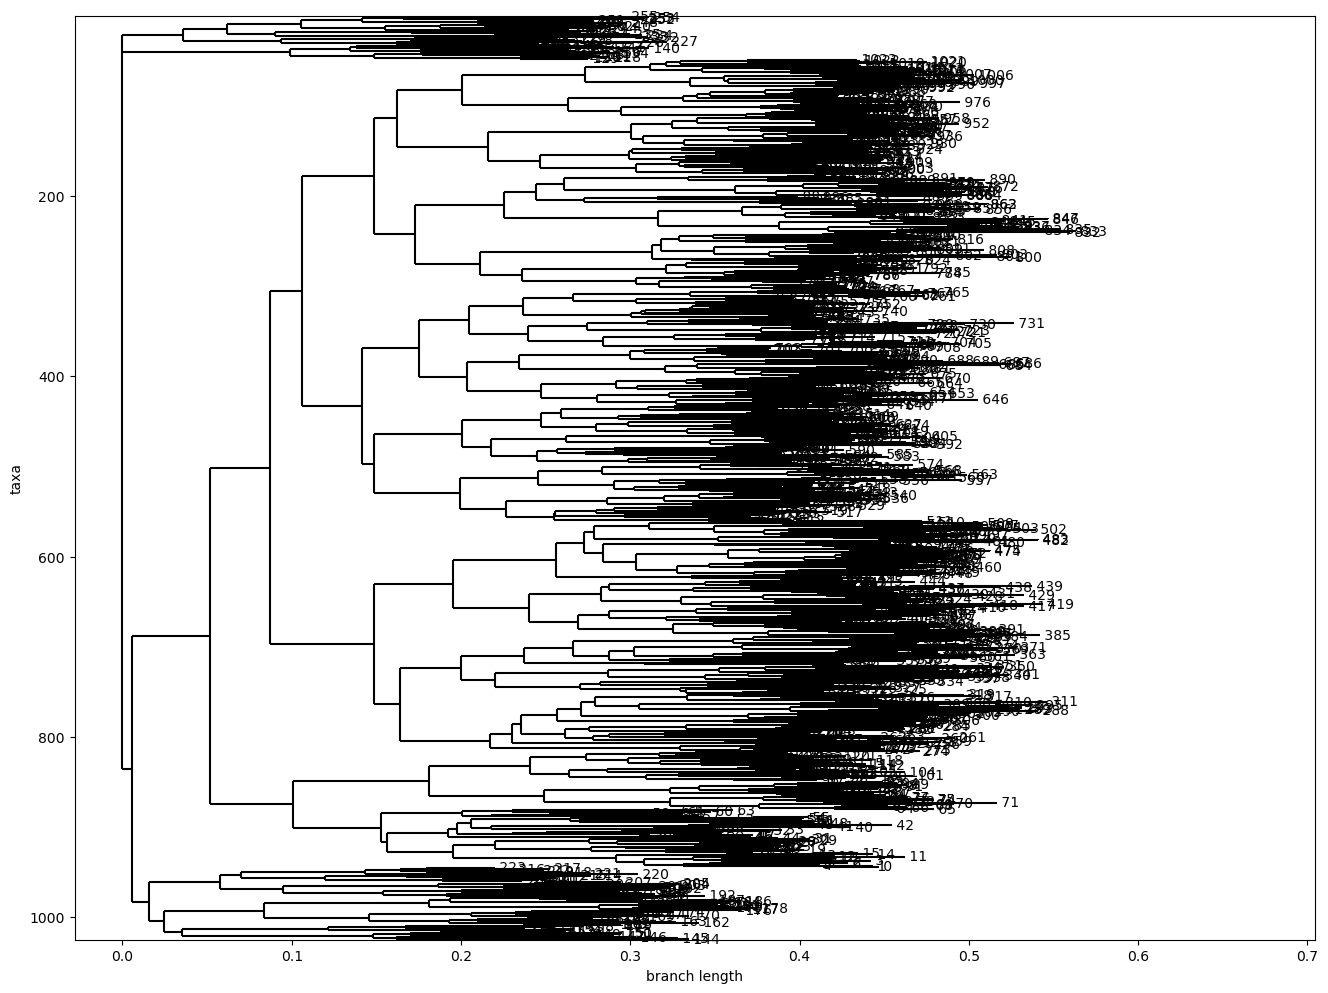

In [67]:
d_hamming = distance.squareform(distance.pdist(cm,metric = "hamming"))
tree = neighbor_joining(d_hamming)
tree_newick = tree.to_newick()
with open("./data/nj_newick.txt", "w") as text_file:
    text_file.write(tree_newick)
tree_phylo = Phylo.read("./data/nj_newick.txt", "newick")
Phylo.draw(tree_phylo)

In [68]:
spatial_count = pd.read_csv('./data/spatial_counts.csv',sep = " ")
Y = spatial_count.to_numpy()

spatial_meta = pd.read_csv('./data/spatial_meta.csv',sep = ",")
v = spatial_meta[["x", "y"]]
v = v.to_numpy()
spatial_map = pd.read_csv("./data/spatial_map.csv",sep = "\t")

clone_id,Z_clone = temso_utils.Define_clones(tree=tree_phylo)
d = spatial_meta.density.values

Input tree root has more than 2 children. Will run reroot and binarize the tree.


In [69]:
training_genes = range(500)
lambda_d = 0
lambda_g1 = 1
lambda_g2 = 1
lambda_r = 0.1
lambda_l = 0.01
lambda_c = 0.01
lambda_u = 0.001
lambda_cu = 0
d_source = None

learning_rate = 0.001
random_state = np.random.seed(seed=1)
num_epochs = 4000

device = "cuda:3"
device = torch.device(device)  # for gpu


print_each = 100

hyperparameters = {
    "lambda_d": lambda_d,  # KL (ie density) term
    "lambda_g1": lambda_g1,  # gene-voxel cos sim
    "lambda_g2": lambda_g2,  # voxel-gene cos sim
    "lambda_r": lambda_r,  # regularizer: penalize entropy
    "lambda_l": lambda_l,  # regularizer: penalize lineage dissimilarity
    "lambda_c": lambda_c,  # regularizer: penalize clone dissimilarity
    "lambda_u": lambda_u, #regularizer: penalize non-unimodal distribution of each cell's inferred location
    "lambda_cu": lambda_cu, #regularizer: penalize non-uniform distribution of the overall distribution of cells
    "d_source": d_source,
}


logging.info(
    "Begin training with {} genes and with density_prior...".format(
        len(training_genes)
    )
)

INFO:root:Begin training with 500 genes and with density_prior...


In [70]:
mapper = Mapper.Mapper(
    X=X, Y=Y, Z=d_hamming, Z_clone=Z_clone, v=v, d=None, device=device, random_state=random_state, **hyperparameters
)


In [71]:
mapping_matrix, training_history = mapper.train(
    learning_rate=learning_rate, num_epochs=num_epochs, print_each=print_each
)

INFO:root:Printing scores every 100 epochs.


Score: 0.697, VG reg: 0.961, Entropy reg: -0.031, Lineage reg: 0.261, Clone reg: -0.502, Unimodal reg: 4.834
Score: 0.719, VG reg: 0.965, Entropy reg: -0.031, Lineage reg: 0.246, Clone reg: -0.502, Unimodal reg: 4.672
Score: 0.736, VG reg: 0.969, Entropy reg: -0.031, Lineage reg: 0.236, Clone reg: -0.505, Unimodal reg: 4.540
Score: 0.750, VG reg: 0.973, Entropy reg: -0.031, Lineage reg: 0.229, Clone reg: -0.509, Unimodal reg: 4.432
Score: 0.762, VG reg: 0.976, Entropy reg: -0.031, Lineage reg: 0.225, Clone reg: -0.516, Unimodal reg: 4.343
Score: 0.772, VG reg: 0.978, Entropy reg: -0.031, Lineage reg: 0.223, Clone reg: -0.524, Unimodal reg: 4.270
Score: 0.782, VG reg: 0.981, Entropy reg: -0.031, Lineage reg: 0.221, Clone reg: -0.532, Unimodal reg: 4.208
Score: 0.790, VG reg: 0.983, Entropy reg: -0.030, Lineage reg: 0.220, Clone reg: -0.540, Unimodal reg: 4.155
Score: 0.798, VG reg: 0.984, Entropy reg: -0.030, Lineage reg: 0.218, Clone reg: -0.547, Unimodal reg: 4.109
Score: 0.805, VG re

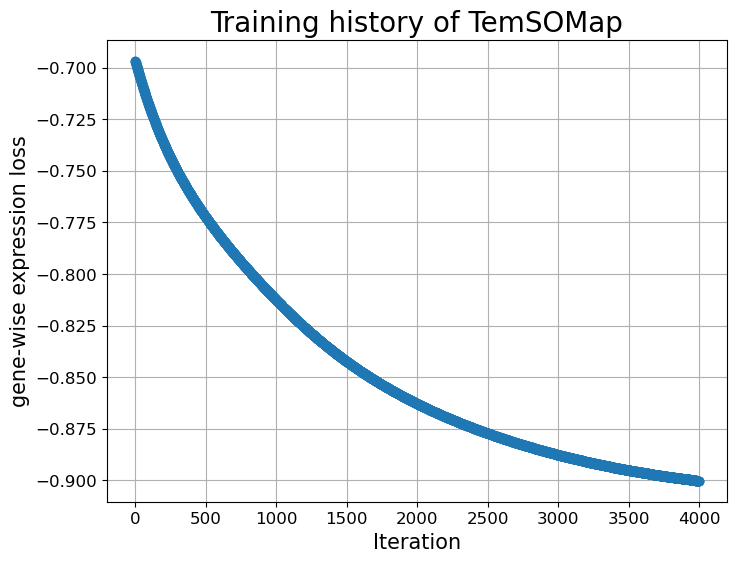

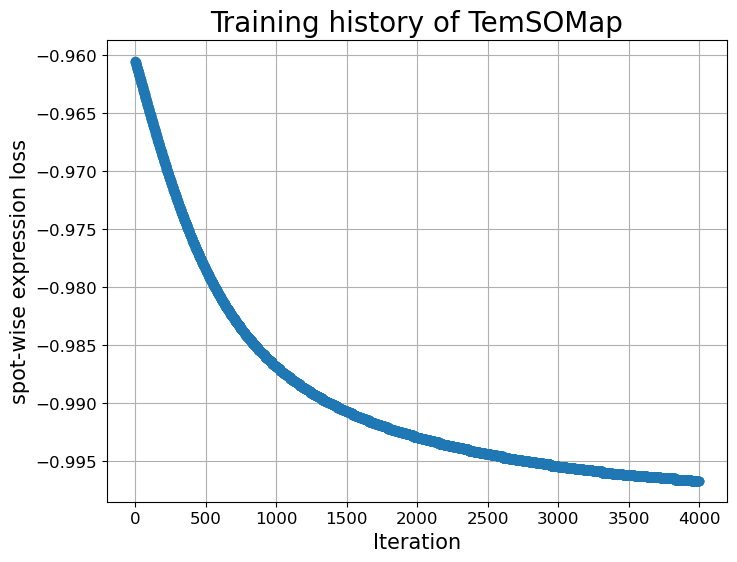

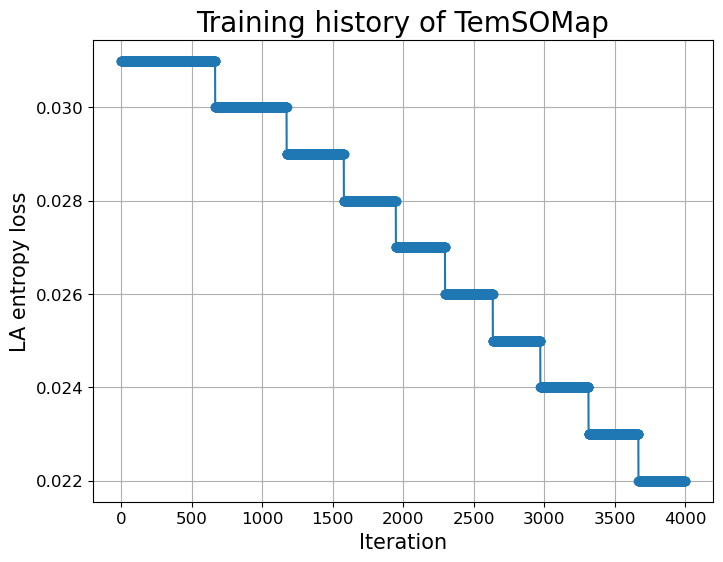

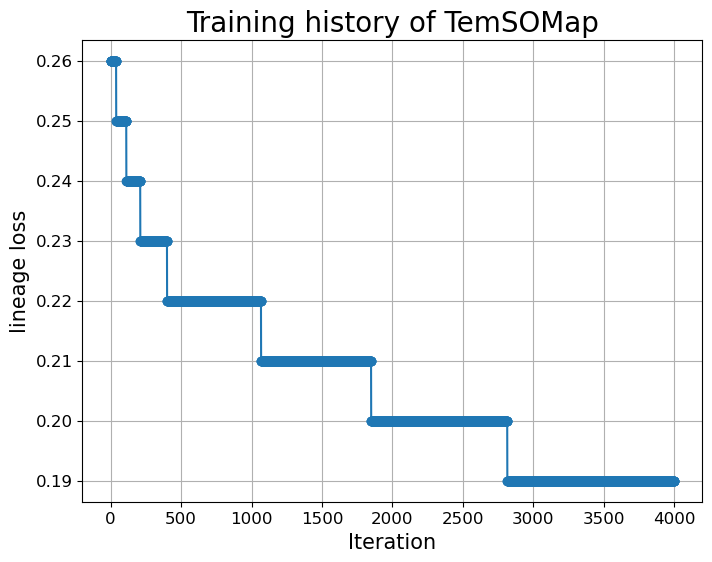

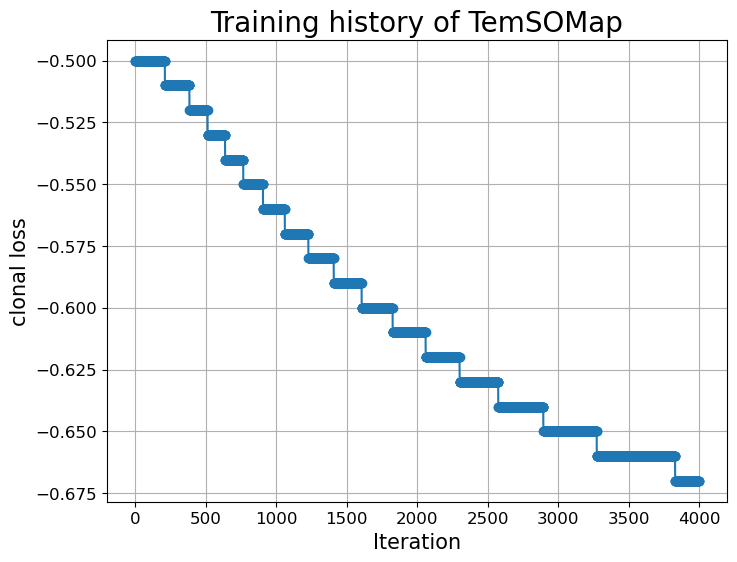

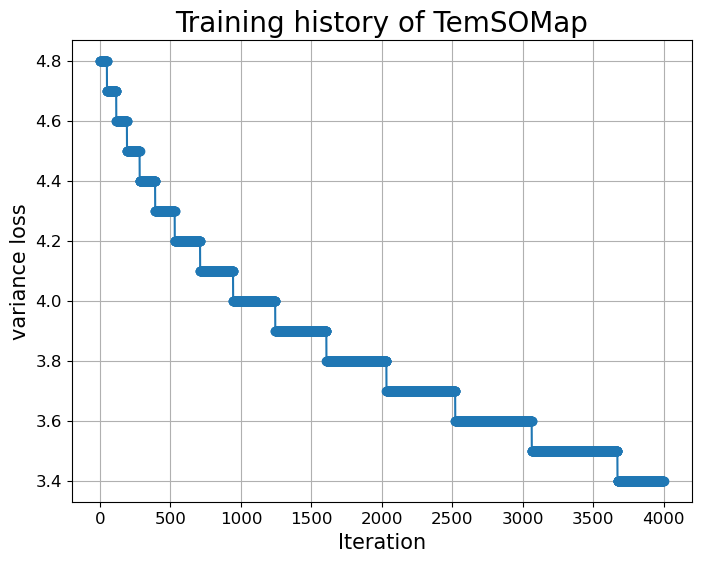

In [72]:
plt.rcParams["figure.figsize"] = (8,6) 
loss_plot = ['gv_loss', 'vg_reg', 'entropy_reg', 'lineage_reg', 'clone_reg', 'unimodal_reg']
h_params = [lambda_g1,lambda_g2,lambda_r,lambda_l,lambda_c,lambda_u]
loss_label = ["gene-wise expression loss","spot-wise expression loss","LA entropy loss","lineage loss","clonal loss","variance loss"]
for i in range(len(loss_plot)):

    curve_vec = training_history[loss_plot[i]]
    lambda_loss = h_params[i]
    numeric_values = []
    plt.figure()
    for string in curve_vec:
        if (len(string) > 5):
            sub1 = "tensor("
            sub2 = ", device"
            idx1 = string.index(sub1)
            idx2 = string.index(sub2)
            if loss_plot[i] in ['gv_loss', 'vg_reg', 'entropy_reg']:
                numeric_values.append(-float(string[(idx1 + len(sub1)):idx2])/lambda_loss)
            else:
                numeric_values.append(float(string[(idx1 + len(sub1)):idx2])/lambda_loss)

    plt.plot(numeric_values, marker='o')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Iteration',fontsize=15)
    plt.ylabel(loss_label[i],fontsize=15)
    plt.title('Training history of TemSOMap',fontsize=20)
    plt.grid(True)

In [73]:
v_gt = spatial_map[["x", "y"]]
v_gt = v_gt.to_numpy()
MSE_st,MSE_coords,N_mismatches,j_index,j_index_whole,l1_coords,pearson_cor,MSE_density = temso_utils.Benchmark_temso(X,Y,mapping_matrix,v_gt,v,d,method="mean")

In [74]:
print(MSE_st,MSE_coords,N_mismatches,j_index,j_index_whole,l1_coords,pearson_cor,MSE_density)
print("The MSE of inferred spatial transcriptomics is: " + str(MSE_st) + ".\n")
print("The MSE of inferred spatial coordinates is: " + str(MSE_coords) + ".\n")

71.2894553892794 2.727727746389589 2048 0.024037109374999987 0.024 1.378614842485749 0.28744076524014034 391.77777777777777
The MSE of inferred spatial transcriptomics is: 71.2894553892794.

The MSE of inferred spatial coordinates is: 2.727727746389589.



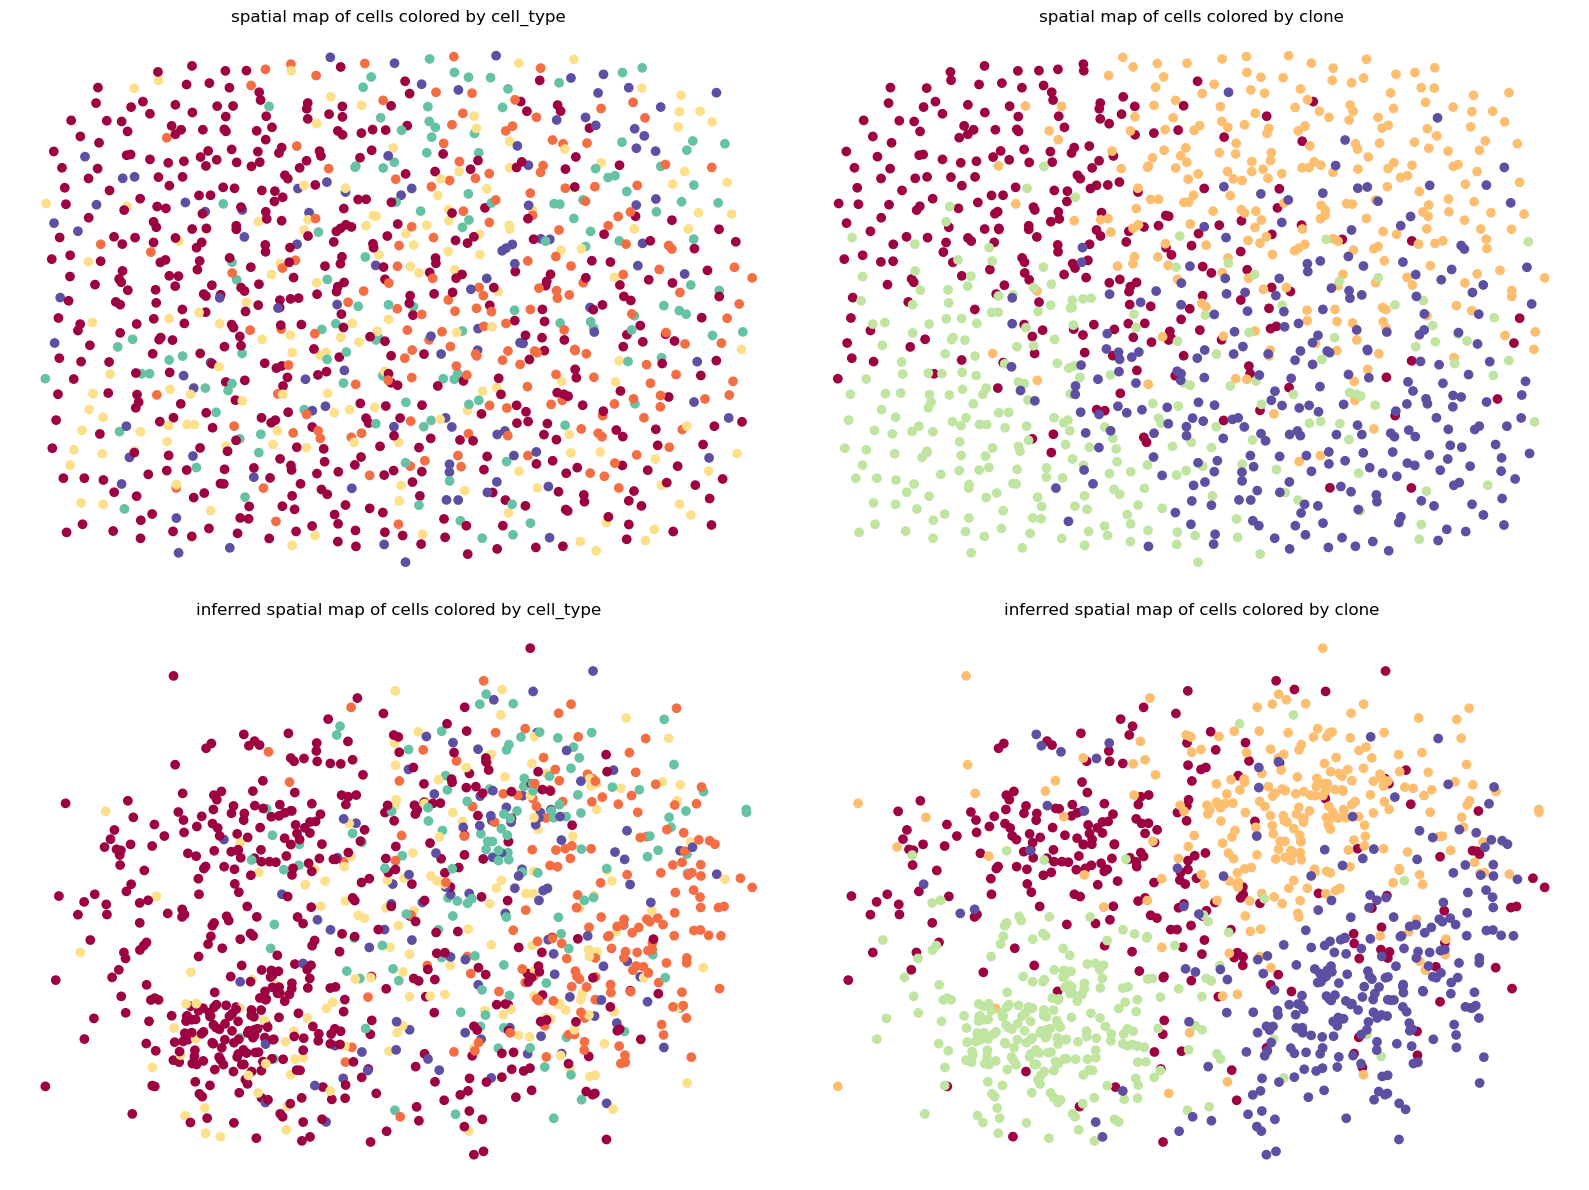

In [75]:
v_pred,M_pred = temso_utils.generate_spatial_map(X,mapping_matrix,v,method = "mean")

plt.rcParams["figure.figsize"] = (16,12) 

plt.subplot(2,2,1)
xs = spatial_map.x.copy().values
ys = spatial_map.y.copy().values

plt.axis('off')
color_map = "cell_type"
plt.scatter(xs, ys, c= spatial_map[color_map].values,cmap=plt.cm.Spectral);
plt.gca().invert_yaxis()
plt.title("spatial map of cells colored by " + color_map);

plt.subplot(2,2,2)
xs = spatial_map.x.copy().values
ys = spatial_map.y.copy().values

plt.axis('off')
color_map = "clone"
plt.scatter(xs, ys, c= spatial_map[color_map].values,cmap=plt.cm.Spectral);
plt.gca().invert_yaxis()
plt.title("spatial map of cells colored by " + color_map);

plt.subplot(2,2,3)
xs = v_pred[:,0] #+ np.random.normal(0, 0.5, v_pred.shape[0])
ys = v_pred[:,1] #+ np.random.normal(0, 0.5, v_pred.shape[0])

plt.axis('off')
color_map = "cell_type"
plt.scatter(xs, ys, c= spatial_map[color_map].values,cmap=plt.cm.Spectral);
plt.gca().invert_yaxis()
plt.title("inferred spatial map of cells colored by " + color_map);

plt.subplot(2,2,4)
plt.axis('off')
color_map = "clone"
plt.scatter(xs, ys, c= spatial_map[color_map].values,cmap=plt.cm.Spectral);
plt.gca().invert_yaxis()
plt.title("inferred spatial map of cells colored by " + color_map);
plt.tight_layout()
plt.show()